In [124]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np

In [98]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='112618acfc6c44749e66db9decc21e1e',
                                                           client_secret='12af8674fb774be4a534fd9c9987877e'))

# import the spotify playlist

In [99]:
def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,3))
    return tracks

In [100]:
from random import randint
from time import sleep

In [101]:
all_tracks=get_playlist_tracks('1G8IpkZKobrIlXcVPoSIuf')

In [102]:
all_track1=get_playlist_tracks('4rnleEAOdmFAbRcNCgZMpY')

In [103]:
all_tracks=all_tracks+all_track1

In [104]:
len(all_tracks)

15295

# Creating a Dataframe of playlist

In [105]:
playlist = sp.user_playlist_tracks("spotify", "1G8IpkZKobrIlXcVPoSIuf")

song_name = []
artist_name = []
track_uri = []
for i in range(len(all_tracks)):
    try:
        song = all_tracks[i]['track']['name']
        artist = all_tracks[i]["track"]["album"]['artists'][0]['name']
        uri = all_tracks[i]['track']['uri']
        artist_name.append(artist)
        song_name.append(song)
        track_uri.append(uri)
    except:
        artist_name.append('none')
        song_name.append('none')
        track_uri.append('none')

spotify_df=pd.DataFrame({'song': song_name,'artist': artist_name,'uri': track_uri})

In [106]:
spotify_df.head()

,song,artist,uri
0,Like a Rolling Stone,Bob Dylan,spotify:track:3AhXZa8sUQht0UEdBJgpGc
1,Smells Like Teen Spirit,Nirvana,spotify:track:3oTlkzk1OtrhH8wBAduVEi
2,A Day In The Life - Remastered,The Beatles,spotify:track:3ZFBeIyP41HhnALjxWy1pR
3,Good Vibrations (Mono),The Beach Boys,spotify:track:5Qt4Cc66g24QWwGP3YYV9y
4,Johnny B Goode,Chuck Berry,spotify:track:7MH2ZclofPlTrZOkPzZKhK


In [107]:
spotify_df.shape

(15295, 3)

# Cleaning the Nan value and duplicates

In [174]:
spotify_df.isna().sum()

song      0
artist    0
uri       0
dtype: int64

In [176]:
spotify_df=spotify_df.dropna()

In [108]:
spotify_df=spotify_df.drop_duplicates(keep='first')

In [175]:
spotify_df=spotify_df.reset_index(drop=True)

# Using uri to get the audio features 

In [109]:
def uri_audio_features(uri):
    #sleep(randint(1,2))
    return sp.audio_features(uri)

In [110]:
spotify_df['uri']=spotify_df['uri'].apply(uri_audio_features)

In [111]:
spotify_df.head()

,song,artist,uri
0,Like a Rolling Stone,Bob Dylan,"[{'danceability': 0.482, 'energy': 0.721, 'key..."
1,Smells Like Teen Spirit,Nirvana,"[{'danceability': 0.485, 'energy': 0.863, 'key..."
2,A Day In The Life - Remastered,The Beatles,"[{'danceability': 0.364, 'energy': 0.457, 'key..."
3,Good Vibrations (Mono),The Beach Boys,"[{'danceability': 0.398, 'energy': 0.413, 'key..."
4,Johnny B Goode,Chuck Berry,"[{'danceability': 0.518, 'energy': 0.756, 'key..."


# Flattening the column

In [116]:
def flatten(data, col_list):
    for column in col_list:
        flattened = pd.DataFrame(dict(data[column])).transpose()
        columns = [str(col) for col in flattened.columns]
        flattened.columns = [column + '_' + colname for colname in columns]
        data = pd.concat([data, flattened], axis=1)
        data = data.drop(column, axis=1)
    return data


In [117]:
flat = flatten(spotify_df, ['uri'])
flat

,song,artist,uri_0
0,Like a Rolling Stone,Bob Dylan,"{'danceability': 0.482, 'energy': 0.721, 'key'..."
1,Smells Like Teen Spirit,Nirvana,"{'danceability': 0.485, 'energy': 0.863, 'key'..."
2,A Day In The Life - Remastered,The Beatles,"{'danceability': 0.364, 'energy': 0.457, 'key'..."
3,Good Vibrations (Mono),The Beach Boys,"{'danceability': 0.398, 'energy': 0.413, 'key'..."
4,Johnny B Goode,Chuck Berry,"{'danceability': 0.518, 'energy': 0.756, 'key'..."
...,...,...,...
15290,Hermit the Frog,MARINA,"{'danceability': 0.609, 'energy': 0.679, 'key'..."
15291,deja vu,Olivia Rodrigo,"{'danceability': 0.439, 'energy': 0.61, 'key':..."
15292,WHOLE LOTTA MONEY,BIA,"{'danceability': 0.897, 'energy': 0.371, 'key'..."
15293,Slumber Party (feat. Princess Nokia),Ashnikko,"{'danceability': 0.964, 'energy': 0.398, 'key'..."


In [114]:
flat1=flatten(flat, ['uri_0'])

In [118]:
data=flat1

In [121]:
data['uri_0_time_signature'].value_counts()

4    14095
3      763
5      121
1       64
0        1
Name: uri_0_time_signature, dtype: int64

# Renaming the columns

In [129]:
cols=[]
for i in range(len(data.columns)):
    cols.append(data.columns[i].lower().replace('uri_0_', ''))
data.columns = cols

print(data.columns)

Index(['song', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')


In [138]:
data=data.dropna()

In [142]:
data=data.reset_index(drop=True)

# Selecting the desired columns

In [143]:
data_num=data[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]

In [144]:
data_num.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.482,0.721,0,-6.839,1,0.0321,0.731,0,0.189,0.557,95.263,369600
1,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.0162,0.138,0.767,116.835,300977
2,0.364,0.457,4,-14.162,0,0.0675,0.29,0.000106,0.922,0.175,163.219,337413
3,0.398,0.413,1,-10.934,1,0.0388,0.0822,0.000025,0.0891,0.331,133.574,219147
4,0.518,0.756,10,-10.851,1,0.0915,0.735,0.000062,0.317,0.968,166.429,160893


In [145]:
data_num.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64

# Converting the columns to numerical columns

In [148]:
for i in data_num.columns:
    data_num[i]=pd.to_numeric(data_num[i],errors='coerce')

C:\Users\Admin\AppData\Local\Temp\ipykernel_1144\916430225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num[i]=pd.to_numeric(data_num[i],errors='coerce')


In [177]:
#data_num.describe().T

In [152]:
data_num.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.482,0.721,0,-6.839,1,0.0321,0.731000,0.000000,0.1890,0.557,95.263,369600
1,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.016200,0.1380,0.767,116.835,300977
2,0.364,0.457,4,-14.162,0,0.0675,0.290000,0.000106,0.9220,0.175,163.219,337413
3,0.398,0.413,1,-10.934,1,0.0388,0.082200,0.000025,0.0891,0.331,133.574,219147
4,0.518,0.756,10,-10.851,1,0.0915,0.735000,0.000062,0.3170,0.968,166.429,160893


# Scaling the columns

In [161]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler().fit(data_num)
X = transformer.transform(data_num)
X_prep = pd.DataFrame(X, columns=data_num.columns)
X_prep.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.487854,0.720994,0.000000,0.866633,1.0,0.034368,0.733936,0.000000,0.183516,0.557,0.437808,0.138193
1,0.490891,0.862997,0.090909,0.830964,1.0,0.052998,0.000012,0.016314,0.131724,0.767,0.536948,0.110653
2,0.368421,0.456989,0.363636,0.747253,0.0,0.072270,0.291165,0.000107,0.927898,0.175,0.750118,0.125276
3,0.402834,0.412988,0.090909,0.799876,1.0,0.041542,0.082530,0.000026,0.082065,0.331,0.613876,0.077812
4,0.524291,0.755995,0.909091,0.801229,1.0,0.097966,0.737952,0.000062,0.313503,0.968,0.764871,0.054433


# Computing the optimal k value

In [158]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

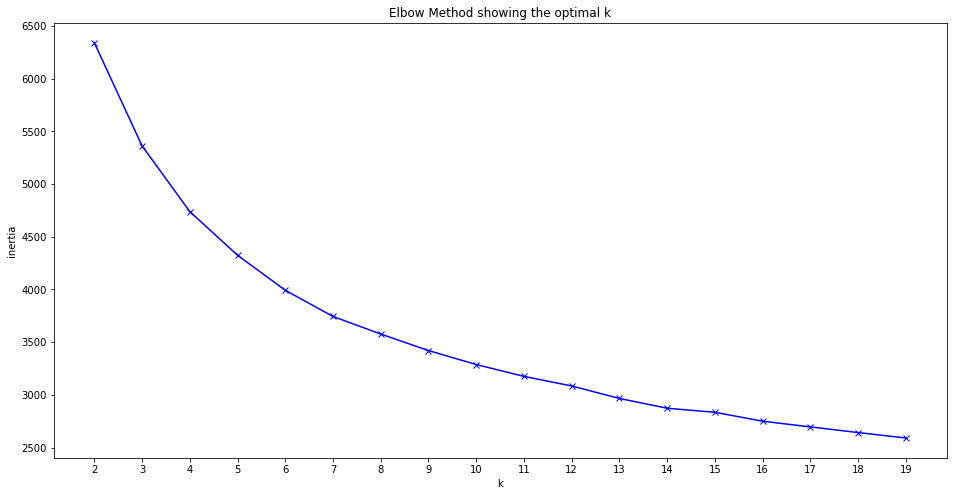

In [162]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

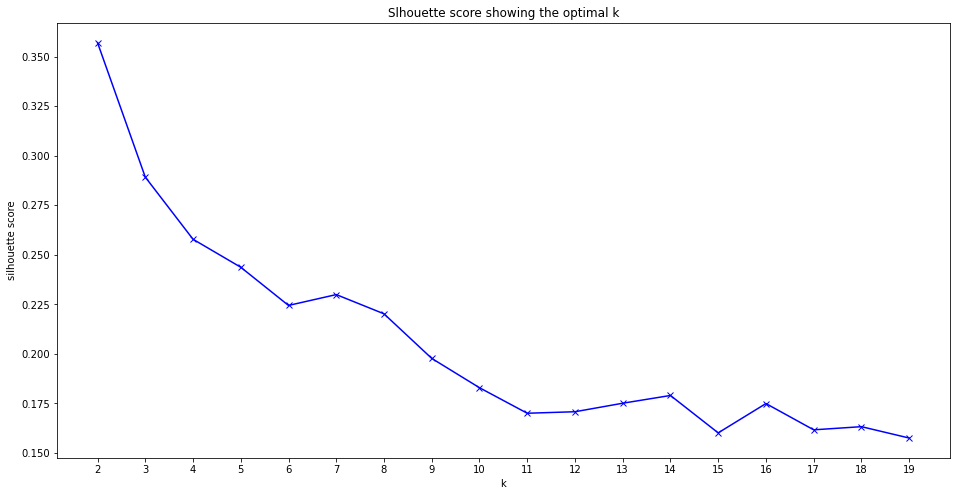

In [163]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

In [164]:
# In terms of the Elbow Method k=3 is optimal but according to the Slhouette score i should choose k=2. I am not sure which one is right.

In [165]:
kmeans = KMeans(n_clusters=3, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=3, random_state=1234)

In [166]:
clusters = kmeans.predict(X_prep)

In [168]:
data_num['cluster']=pd.DataFrame(clusters,columns=['cluster'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_1144\3981799151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num['cluster']=pd.DataFrame(clusters,columns=['cluster'])


In [171]:
data_num.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,cluster
0,0.482,0.721,0,-6.839,1,0.0321,0.731000,0.000000,0.1890,0.557,95.263,369600,1
1,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.016200,0.1380,0.767,116.835,300977,0
2,0.364,0.457,4,-14.162,0,0.0675,0.290000,0.000106,0.9220,0.175,163.219,337413,2
3,0.398,0.413,1,-10.934,1,0.0388,0.082200,0.000025,0.0891,0.331,133.574,219147,0
4,0.518,0.756,10,-10.851,1,0.0915,0.735000,0.000062,0.3170,0.968,166.429,160893,1
